**Incurred & Indemnity

Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.150  1.074  1.030  1.001  0.991  0.992  0.993   1.020      NaN   
2011  1.173  1.093  1.033  1.004  0.995  0.987  0.998   1.047     1.01   
2012  1.343  1.082  1.035  0.996  0.993  1.003  1.003   0.993     1.01   
2013  1.190  1.123  1.028  0.996  0.995  0.998  0.990   1.006     1.02   
2014  1.338  1.130  1.034  1.009  1.002  0.996  0.990   0.994     0.99   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    0.981      NaN      NaN  
2013    1.025    1.019      NaN  
2014    0.994    0.992     0.99  

Detected Outliers (manual + IQR):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2011    NaN    NaN    NaN    NaN    NaN    NaN    NaN   1.047      NaN   
2012  1.343    NaN    NaN    NaN    NaN    NaN    NaN     NaN      NaN   
2013    NaN  1.123    NaN    NaN    NaN    NaN    NaN     NaN      NaN   
2

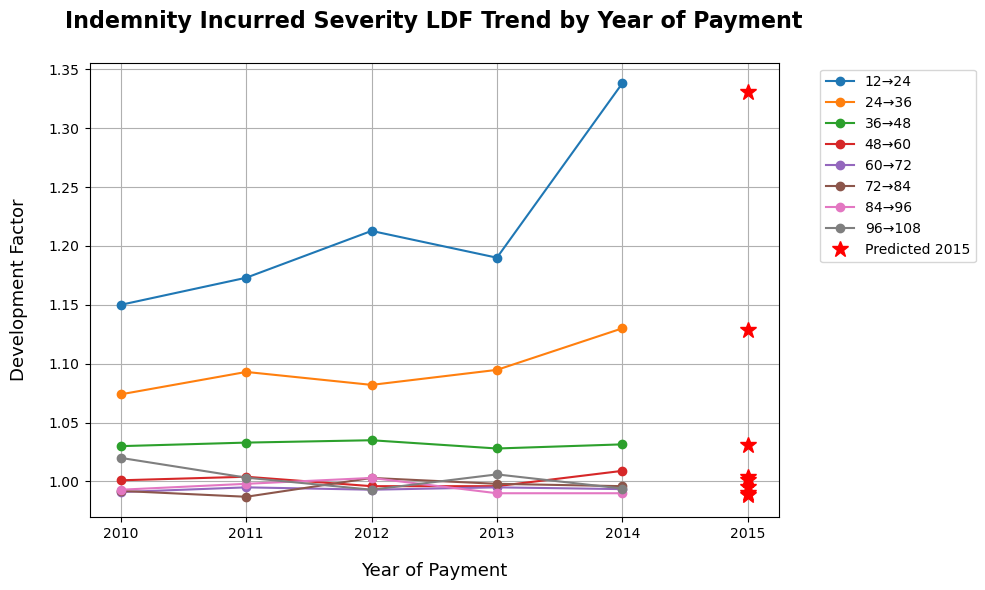

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.150, 1.074, 1.030, 1.001, 0.991, 0.992, 0.993, 1.020, np.nan, np.nan, np.nan, np.nan],
    2011: [1.173, 1.093, 1.033, 1.004, 0.995, 0.987, 0.998, 1.047, 1.010, np.nan, np.nan, np.nan],
    2012: [1.343, 1.082, 1.035, 0.996, 0.993, 1.003, 1.003, 0.993, 1.010, 0.981, np.nan, np.nan],
    2013: [1.190, 1.123, 1.028, 0.996, 0.995, 0.998, 0.990, 1.006, 1.020, 1.025, 1.019, np.nan],
    2014: [1.338, 1.130, 1.034, 1.009, 1.002, 0.996, 0.990, 0.994, 0.990, 0.994, 0.992, 0.990]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually mark specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 1.343
    (2013, "24→36"),  # 1.123
    (2014, "36→48")   # 1.034
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]

print("Detected Outliers (manual + IQR):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 6. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

for col in clean_df.columns[:8]:  # plot first 8 columns for clarity
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

plt.plot([future_year[0]]*8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Indemnity Incurred Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.150  1.074  1.030  1.001  0.991  0.992  0.993   1.020      NaN   
2011  1.173  1.093  1.033  1.004  0.995  0.987  0.998   1.047     1.01   
2012  1.343  1.082  1.035  0.996  0.993  1.003  1.003   0.993     1.01   
2013  1.190  1.123  1.028  0.996  0.995  0.998  0.990   1.006     1.02   
2014  1.338  1.130  1.034  1.009  1.002  0.996  0.990   0.994     0.99   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    0.981      NaN      NaN  
2013    1.025    1.019      NaN  
2014    0.994    0.992     0.99  

Detected Outliers (manual + IQR):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2011    NaN    NaN    NaN    NaN    NaN    NaN    NaN   1.047      NaN   
2012  1.343    NaN    NaN    NaN    NaN    NaN    NaN     NaN      NaN   
2013    NaN  1.123    NaN    NaN    NaN    NaN    NaN     NaN      NaN   
2

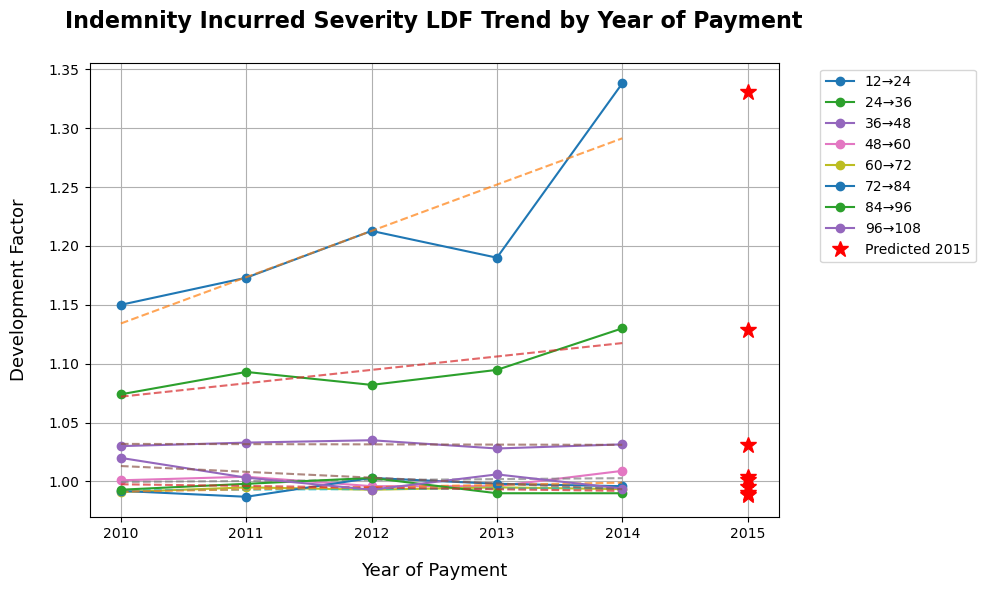

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.150, 1.074, 1.030, 1.001, 0.991, 0.992, 0.993, 1.020, np.nan, np.nan, np.nan, np.nan],
    2011: [1.173, 1.093, 1.033, 1.004, 0.995, 0.987, 0.998, 1.047, 1.010, np.nan, np.nan, np.nan],
    2012: [1.343, 1.082, 1.035, 0.996, 0.993, 1.003, 1.003, 0.993, 1.010, 0.981, np.nan, np.nan],
    2013: [1.190, 1.123, 1.028, 0.996, 0.995, 0.998, 0.990, 1.006, 1.020, 1.025, 1.019, np.nan],
    2014: [1.338, 1.130, 1.034, 1.009, 1.002, 0.996, 0.990, 0.994, 0.990, 0.994, 0.992, 0.990]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually mark specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 1.343
    (2013, "24→36"),  # 1.123
    (2014, "36→48")   # 1.034
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]

print("Detected Outliers (manual + IQR):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
mae_list, rmse_list = [], []

plt.figure(figsize=(10, 6))

for i, col in enumerate(clean_df.columns):
    y = clean_df[col].values
    mask = ~np.isnan(y)

    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    y_pred = model.predict(years[mask])

    mae = mean_absolute_error(y[mask], y_pred)
    rmse = np.sqrt(mean_squared_error(y[mask], y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)

    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)

    # Only plot first 8 columns for clarity
    if i < 8:
        plt.plot(clean_df.index, clean_df[col], marker='o', label=col)
        plt.plot(clean_df.index, y_pred, linestyle='--', alpha=0.7)

# ------------------------------
# 6. Display Predicted Ratios
# ------------------------------
predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 7. Calculate and Display Average MAE & RMSE
# ------------------------------
avg_mae = np.mean(mae_list)
avg_rmse = np.mean(rmse_list)

print(f"Average MAE across regressions: {avg_mae:.5f}")
print(f"Average RMSE across regressions: {avg_rmse:.5f}")
print()

# ------------------------------
# 8. Final Visualization
# ------------------------------
plt.plot([future_year[0]]*8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Indemnity Incurred Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Paid & Indemnity

Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  2.316  1.473  1.206  1.115  1.060  1.030  1.015   1.025      NaN   
2011  2.345  1.527  1.236  1.137  1.066  1.032  1.022   1.037    1.023   
2012  2.969  1.503  1.230  1.118  1.057  1.040  1.025   1.003    1.014   
2013  2.552  1.524  1.236  1.117  1.061  1.030  1.017   1.024    1.026   
2014  2.547  1.509  1.237  1.115  1.060  1.027  1.015   1.012    1.011   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    1.000      NaN      NaN  
2013    1.035    1.021      NaN  
2014    1.012    1.019    1.007  

Detected Outliers (manual + statistical):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN  1.473  1.206    NaN    NaN    NaN    NaN     NaN      NaN   
2011    NaN    NaN    NaN  1.137  1.066    NaN    NaN     NaN      NaN   
2012  2.969    NaN    NaN    NaN  1.057  1.040    NaN     NaN      

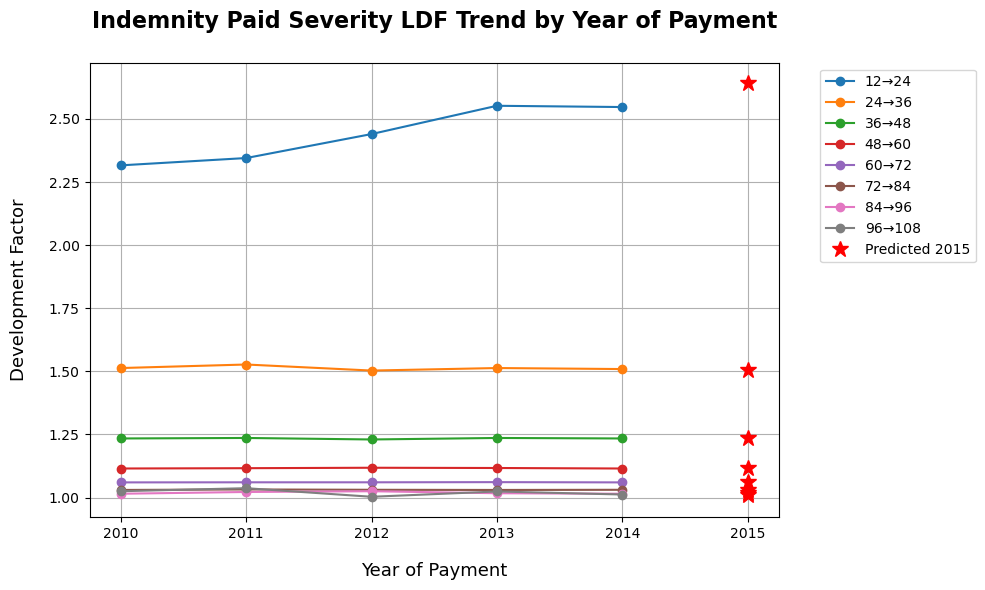

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [2.316, 1.473, 1.206, 1.115, 1.060, 1.030, 1.015, 1.025, np.nan, np.nan, np.nan, np.nan],
    2011: [2.345, 1.527, 1.236, 1.137, 1.066, 1.032, 1.022, 1.037, 1.023, np.nan, np.nan, np.nan],
    2012: [2.969, 1.503, 1.230, 1.118, 1.057, 1.040, 1.025, 1.003, 1.014, 1.000, np.nan, np.nan],
    2013: [2.552, 1.524, 1.236, 1.117, 1.061, 1.030, 1.017, 1.024, 1.026, 1.035, 1.021, np.nan],
    2014: [2.547, 1.509, 1.237, 1.115, 1.060, 1.027, 1.015, 1.012, 1.011, 1.012, 1.019, 1.007]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually mark specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 2.969
    (2013, "24→36"),  # 1.524
    (2014, "36→48")   # 1.237
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]
print("Detected Outliers (manual + statistical):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 6. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

for col in clean_df.columns[:8]:  # show first 8 columns for clarity
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

plt.plot([future_year[0]]*8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Indemnity Paid Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  2.316  1.473  1.206  1.115  1.060  1.030  1.015   1.025      NaN   
2011  2.345  1.527  1.236  1.137  1.066  1.032  1.022   1.037    1.023   
2012  2.969  1.503  1.230  1.118  1.057  1.040  1.025   1.003    1.014   
2013  2.552  1.524  1.236  1.117  1.061  1.030  1.017   1.024    1.026   
2014  2.547  1.509  1.237  1.115  1.060  1.027  1.015   1.012    1.011   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    1.000      NaN      NaN  
2013    1.035    1.021      NaN  
2014    1.012    1.019    1.007  

Detected Outliers (manual + statistical):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN  1.473  1.206    NaN    NaN    NaN    NaN     NaN      NaN   
2011    NaN    NaN    NaN  1.137  1.066    NaN    NaN     NaN      NaN   
2012  2.969    NaN    NaN    NaN  1.057  1.040    NaN     NaN      

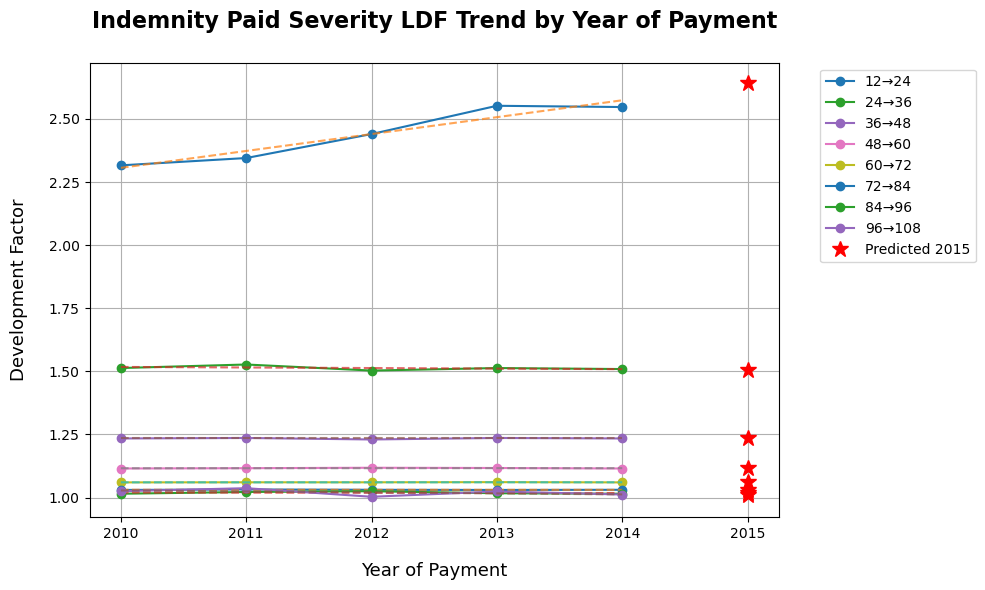

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [2.316, 1.473, 1.206, 1.115, 1.060, 1.030, 1.015, 1.025, np.nan, np.nan, np.nan, np.nan],
    2011: [2.345, 1.527, 1.236, 1.137, 1.066, 1.032, 1.022, 1.037, 1.023, np.nan, np.nan, np.nan],
    2012: [2.969, 1.503, 1.230, 1.118, 1.057, 1.040, 1.025, 1.003, 1.014, 1.000, np.nan, np.nan],
    2013: [2.552, 1.524, 1.236, 1.117, 1.061, 1.030, 1.017, 1.024, 1.026, 1.035, 1.021, np.nan],
    2014: [2.547, 1.509, 1.237, 1.115, 1.060, 1.027, 1.015, 1.012, 1.011, 1.012, 1.019, 1.007]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually mark specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 2.969
    (2013, "24→36"),  # 1.524
    (2014, "36→48")   # 1.237
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]
print("Detected Outliers (manual + statistical):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
mae_list, rmse_list = [], []

plt.figure(figsize=(10, 6))

for i, col in enumerate(clean_df.columns):
    y = clean_df[col].values
    mask = ~np.isnan(y)

    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    y_pred = model.predict(years[mask])

    # Compute error metrics
    mae = mean_absolute_error(y[mask], y_pred)
    rmse = np.sqrt(mean_squared_error(y[mask], y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)

    # Predict for the next year
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)

    # Plot first 8 columns for clarity
    if i < 8:
        plt.plot(clean_df.index, clean_df[col], marker='o', label=col)
        plt.plot(clean_df.index, y_pred, linestyle='--', alpha=0.7)

# ------------------------------
# 6. Display predicted ratios
# ------------------------------
predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 7. Calculate and display average MAE & RMSE
# ------------------------------
avg_mae = np.mean(mae_list)
avg_rmse = np.mean(rmse_list)

print(f"Average MAE across regressions: {avg_mae:.5f}")
print(f"Average RMSE across regressions: {avg_rmse:.5f}")
print()

# ------------------------------
# 8. Final visualization
# ------------------------------
plt.plot([future_year[0]] * 8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Indemnity Paid Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


**Reported & Medical

Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.080  0.978  0.989  0.986  0.994  0.989  1.004   1.057      NaN   
2011  1.083  1.004  1.003  0.984  0.989  0.985  0.994   1.030    1.038   
2012  1.239  0.977  0.990  0.984  0.990  0.983  1.011   1.042    0.998   
2013  1.090  1.037  0.974  0.975  0.992  0.987  0.997   1.030    1.057   
2014  1.184  1.009  0.978  0.996  0.989  0.986  0.997   1.017    1.007   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    0.989      NaN      NaN  
2013    1.022    1.020      NaN  
2014    1.005    0.991     0.99  

Detected Outliers (manual + statistical):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN    NaN    NaN    NaN   1.057      NaN   
2011    NaN    NaN  1.003    NaN    NaN    NaN    NaN     NaN      NaN   
2012  1.239    NaN    NaN    NaN    NaN    NaN    NaN     NaN      

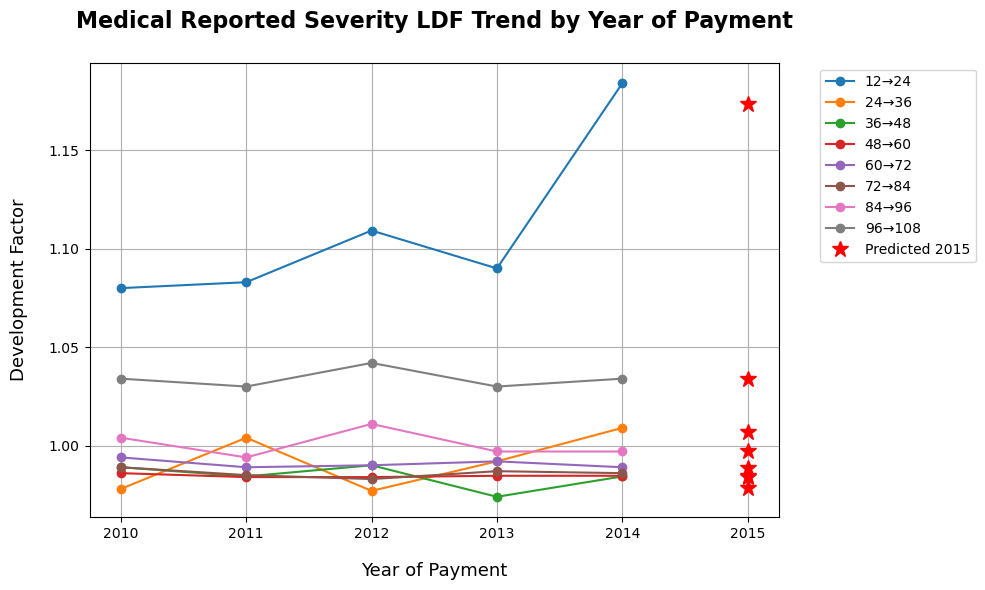

In [15]:
# import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.080, 0.978, 0.989, 0.986, 0.994, 0.989, 1.004, 1.057, np.nan, np.nan, np.nan, np.nan],
    2011: [1.083, 1.004, 1.003, 0.984, 0.989, 0.985, 0.994, 1.030, 1.038, np.nan, np.nan, np.nan],
    2012: [1.239, 0.977, 0.990, 0.984, 0.990, 0.983, 1.011, 1.042, 0.998, 0.989, np.nan, np.nan],
    2013: [1.090, 1.037, 0.974, 0.975, 0.992, 0.987, 0.997, 1.030, 1.057, 1.022, 1.020, np.nan],
    2014: [1.184, 1.009, 0.978, 0.996, 0.989, 0.986, 0.997, 1.017, 1.007, 1.005, 0.991, 0.990]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually flag specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 1.239
    (2013, "24→36"),  # 1.037
    (2014, "36→48")   # 0.978
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]
print("Detected Outliers (manual + statistical):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 6. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

for col in clean_df.columns[:8]:  # show first 8 columns for clarity
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

plt.plot([future_year[0]] * 8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Medical Reported Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.080  0.978  0.989  0.986  0.994  0.989  1.004   1.057      NaN   
2011  1.083  1.004  1.003  0.984  0.989  0.985  0.994   1.030    1.038   
2012  1.239  0.977  0.990  0.984  0.990  0.983  1.011   1.042    0.998   
2013  1.090  1.037  0.974  0.975  0.992  0.987  0.997   1.030    1.057   
2014  1.184  1.009  0.978  0.996  0.989  0.986  0.997   1.017    1.007   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    0.989      NaN      NaN  
2013    1.022    1.020      NaN  
2014    1.005    0.991     0.99  

Detected Outliers (manual + statistical):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN    NaN    NaN    NaN   1.057      NaN   
2011    NaN    NaN  1.003    NaN    NaN    NaN    NaN     NaN      NaN   
2012  1.239    NaN    NaN    NaN    NaN  0.983    NaN     NaN      

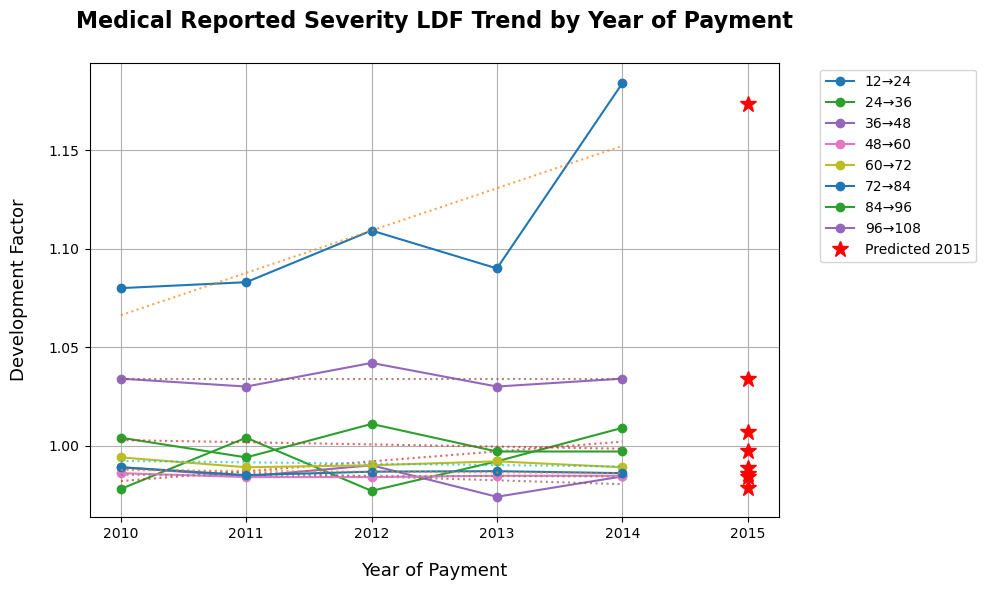

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.080, 0.978, 0.989, 0.986, 0.994, 0.989, 1.004, 1.057, np.nan, np.nan, np.nan, np.nan],
    2011: [1.083, 1.004, 1.003, 0.984, 0.989, 0.985, 0.994, 1.030, 1.038, np.nan, np.nan, np.nan],
    2012: [1.239, 0.977, 0.990, 0.984, 0.990, 0.983, 1.011, 1.042, 0.998, 0.989, np.nan, np.nan],
    2013: [1.090, 1.037, 0.974, 0.975, 0.992, 0.987, 0.997, 1.030, 1.057, 1.022, 1.020, np.nan],
    2014: [1.184, 1.009, 0.978, 0.996, 0.989, 0.986, 0.997, 1.017, 1.007, 1.005, 0.991, 0.990]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually flag specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 1.239
    (2013, "24→36"),  # 1.037
    (2014, "36→48")   # 0.978
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]
print("Detected Outliers (manual + statistical):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

mae_list, rmse_list = [], []
predicted_ratios = []

for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)
    
    # --- Performance metrics ---
    y_pred_in = model.predict(years[mask])
    mae = mean_absolute_error(y[mask], y_pred_in)
    rmse = np.sqrt(mean_squared_error(y[mask], y_pred_in))
    mae_list.append(mae)
    rmse_list.append(rmse)

# Compute average MAE and RMSE across all columns
avg_mae = np.nanmean(mae_list)
avg_rmse = np.nanmean(rmse_list)

print(f"Average MAE across columns: {avg_mae:.4f}")
print(f"Average RMSE across columns: {avg_rmse:.4f}\n")

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 6. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

for col in clean_df.columns[:8]:  # plot first 8 columns for clarity
    mask = ~np.isnan(clean_df[col])
    plt.plot(clean_df.index[mask], clean_df[col][mask], marker='o', label=col)
    
    # Add dotted regression line
    model = LinearRegression()
    model.fit(years[mask], clean_df[col][mask])
    y_fit = model.predict(years[mask])
    plt.plot(clean_df.index[mask], y_fit, linestyle='dotted', alpha=0.7)

# Plot predicted next-year points
plt.plot([future_year[0]] * 8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Medical Reported Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Paid & Medical

Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.668  1.092  1.044  1.022  1.016  1.005  1.003   1.039      NaN   
2011  1.678  1.101  1.039  1.021  1.009  1.006  1.005   1.026    1.037   
2012  1.862  1.083  1.041  1.016  1.008  1.003  1.008   1.019    1.003   
2013  1.735  1.113  1.037  1.015  1.006  1.006  1.003   1.021    1.042   
2014  1.726  1.095  1.095  1.018  1.009  1.002  1.004   1.016    1.009   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    1.010      NaN      NaN  
2013    1.025    1.034      NaN  
2014    1.026    1.010    1.025  

Detected Outliers (manual + statistical):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN  1.016    NaN    NaN   1.039      NaN   
2012  1.862  1.083    NaN    NaN    NaN    NaN  1.008     NaN      NaN   
2013    NaN  1.113    NaN    NaN  1.006    NaN    NaN     NaN      

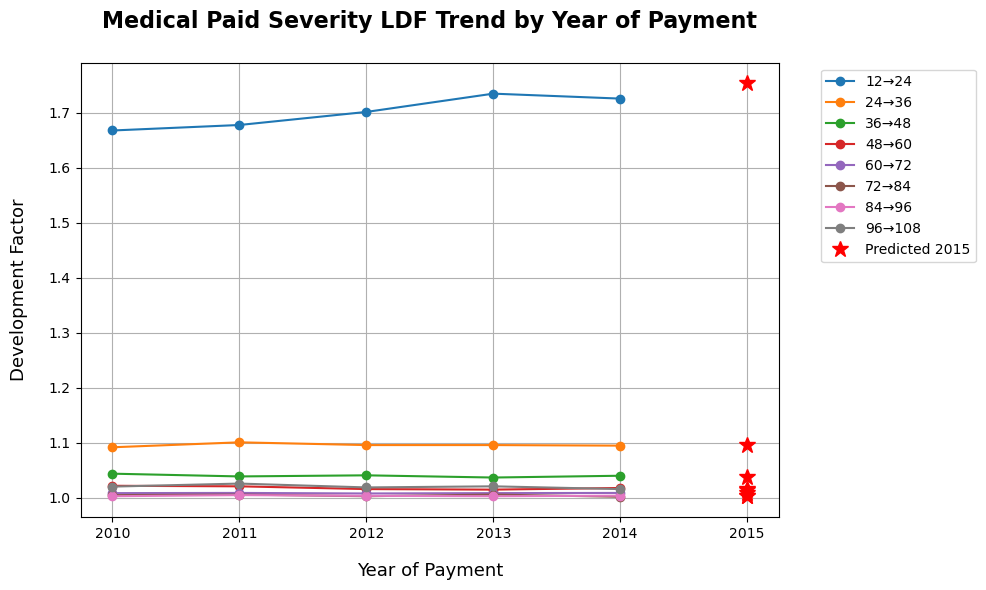

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.668, 1.092, 1.044, 1.022, 1.016, 1.005, 1.003, 1.039, np.nan, np.nan, np.nan, np.nan],
    2011: [1.678, 1.101, 1.039, 1.021, 1.009, 1.006, 1.005, 1.026, 1.037, np.nan, np.nan, np.nan],
    2012: [1.862, 1.083, 1.041, 1.016, 1.008, 1.003, 1.008, 1.019, 1.003, 1.010, np.nan, np.nan],
    2013: [1.735, 1.113, 1.037, 1.015, 1.006, 1.006, 1.003, 1.021, 1.042, 1.025, 1.034, np.nan],
    2014: [1.726, 1.095, 1.095, 1.018, 1.009, 1.002, 1.004, 1.016, 1.009, 1.026, 1.010, 1.025]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually flag specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 1.862
    (2013, "24→36"),  # 1.113
    (2014, "36→48")   # 1.095
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]
print("Detected Outliers (manual + statistical):")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3))
print()

# ------------------------------
# 5. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3))
print()

# ------------------------------
# 6. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

for col in clean_df.columns[:8]:  # first 8 for clarity
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

plt.plot([future_year[0]] * 8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Medical Paid Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.668  1.092  1.044  1.022  1.016  1.005  1.003   1.039      NaN   
2011  1.678  1.101  1.039  1.021  1.009  1.006  1.005   1.026    1.037   
2012  1.862  1.083  1.041  1.016  1.008  1.003  1.008   1.019    1.003   
2013  1.735  1.113  1.037  1.015  1.006  1.006  1.003   1.021    1.042   
2014  1.726  1.095  1.095  1.018  1.009  1.002  1.004   1.016    1.009   

      120→132  132→144  144→156  
2010      NaN      NaN      NaN  
2011      NaN      NaN      NaN  
2012    1.010      NaN      NaN  
2013    1.025    1.034      NaN  
2014    1.026    1.010    1.025   

Detected Outliers (manual + statistical):
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN  1.016    NaN    NaN   1.039      NaN   
2012  1.862  1.083    NaN    NaN    NaN    NaN  1.008     NaN      NaN   
2013    NaN  1.113    NaN    NaN  1.006    NaN    NaN     NaN     

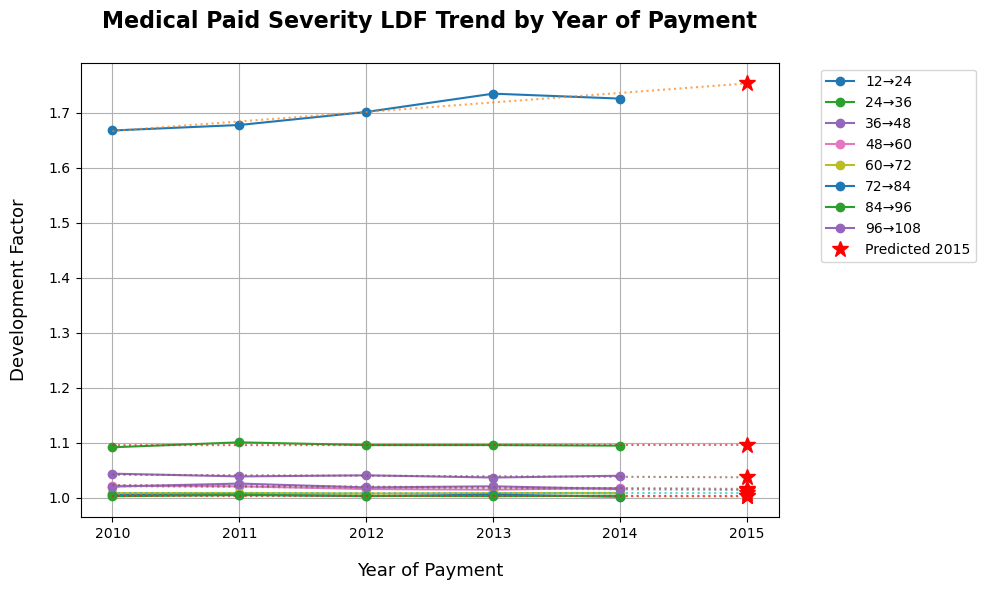

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.668, 1.092, 1.044, 1.022, 1.016, 1.005, 1.003, 1.039, np.nan, np.nan, np.nan, np.nan],
    2011: [1.678, 1.101, 1.039, 1.021, 1.009, 1.006, 1.005, 1.026, 1.037, np.nan, np.nan, np.nan],
    2012: [1.862, 1.083, 1.041, 1.016, 1.008, 1.003, 1.008, 1.019, 1.003, 1.010, np.nan, np.nan],
    2013: [1.735, 1.113, 1.037, 1.015, 1.006, 1.006, 1.003, 1.021, 1.042, 1.025, 1.034, np.nan],
    2014: [1.726, 1.095, 1.095, 1.018, 1.009, 1.002, 1.004, 1.016, 1.009, 1.026, 1.010, 1.025]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df, "\n")

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)

# ------------------------------
# 3. Manually flag specific outliers
# ------------------------------
manual_outliers = [
    (2012, "12→24"),  # 1.862
    (2013, "24→36"),  # 1.113
    (2014, "36→48")   # 1.095
]

for year, col in manual_outliers:
    outlier_mask.loc[year, col] = True

outliers = df[outlier_mask]
print("Detected Outliers (manual + statistical):")
print(outliers.dropna(how="all"), "\n")

# ------------------------------
# 4. Replace Outliers with Column Mean
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.mean()), axis=0)

print("Cleaned Triangle (Outliers replaced with column mean):")
print(clean_df.round(3), "\n")

# ------------------------------
# 5. Predict next year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)
future_year = np.array([clean_df.index.max() + 1])

predicted_ratios, mae_list, rmse_list = [], [], []

for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)

    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue

    model = LinearRegression()
    model.fit(years[mask], y[mask])
    y_pred = model.predict(years[mask])
    pred_future = model.predict(future_year.reshape(-1, 1))[0]
    predicted_ratios.append(pred_future)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y[mask], y_pred)
    rmse = np.sqrt(mean_squared_error(y[mask], y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)

# Compute average MAE and RMSE
avg_mae = np.nanmean(mae_list)
avg_rmse = np.nanmean(rmse_list)

print(f"Average MAE across columns: {avg_mae:.5f}")
print(f"Average RMSE across columns: {avg_rmse:.5f}\n")

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year (Linear Regression):")
print(predicted_row.round(3), "\n")

# ------------------------------
# 6. Visualization
# ------------------------------
plt.figure(figsize=(10, 6))

for col in clean_df.columns[:8]:  # limit to first 8 for clarity
    mask = ~np.isnan(clean_df[col])
    plt.plot(clean_df.index[mask], clean_df[col][mask], marker='o', label=col)

    # Dotted regression line (including extrapolation to predicted year)
    model = LinearRegression()
    model.fit(years[mask], clean_df[col][mask])
    extended_years = np.append(years[mask], future_year).reshape(-1, 1)
    y_fit = model.predict(extended_years)
    plt.plot(extended_years, y_fit, linestyle='dotted', alpha=0.7)

# Plot predicted future points
plt.plot([future_year[0]] * 8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Medical Paid Severity LDF Trend by Year of Payment",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Year of Payment", fontsize=13, labelpad=15)
plt.ylabel("Development Factor", fontsize=13, labelpad=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


**Incurred Indemnity Tail Factors

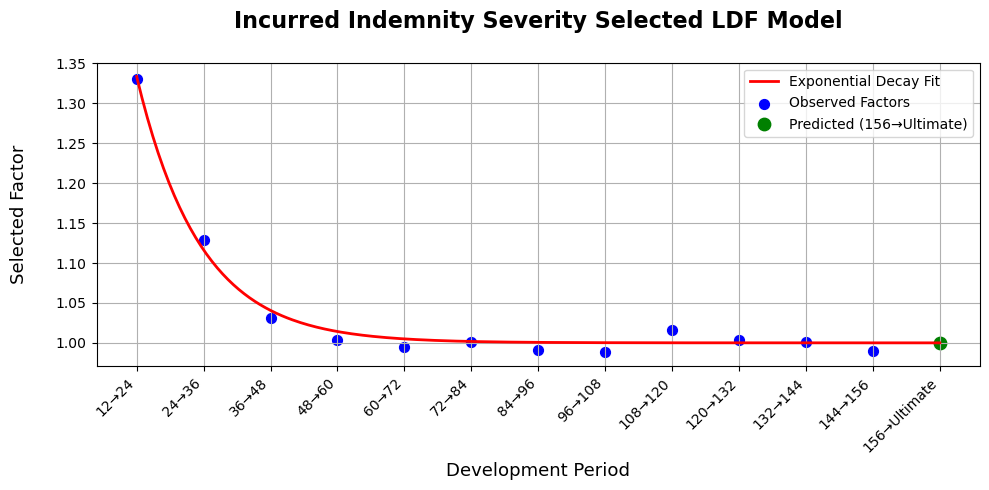

Model Performance Metrics:
  R² (Coefficient of Determination): 0.9901
  MAE (Mean Absolute Error):        0.0082
  RMSE (Root Mean Squared Error):   0.0095

Predicted factor for 156→Ultimate: 1.0000


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------------------------------------
# 1. Data
# --------------------------------------
periods = [
    "12→24", "24→36", "36→48", "48→60", "60→72", "72→84",
    "84→96", "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ultimate"
]

ages = np.array([24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156])
factors = np.array([1.331, 1.129, 1.031, 1.004, 0.995, 1.001, 0.991, 0.988, 1.016, 1.004, 1.001, 0.990])

# --------------------------------------
# 2. Define decaying exponential model
# --------------------------------------
def exp_decay(x, A, B):
    return 1 + A * np.exp(-B * x)

# --------------------------------------
# 3. Fit model
# --------------------------------------
p0 = [0.3, 0.01]  # initial guesses for A, B
params, _ = curve_fit(exp_decay, ages, factors, p0=p0, maxfev=10000)
A, B = params

# --------------------------------------
# 4. Model predictions and error metrics
# --------------------------------------
fitted_values = exp_decay(ages, A, B)
r2 = r2_score(factors, fitted_values)
mae = mean_absolute_error(factors, fitted_values)
rmse = np.sqrt(mean_squared_error(factors, fitted_values))

# Predict next factor (156→Ultimate)
predicted_factor = exp_decay(168, A, B)

# --------------------------------------
# 5. Plot (fitted curve + observed points + prediction)
# --------------------------------------
plt.figure(figsize=(10, 5))

# Fitted curve
x_fit = np.linspace(24, 168, 300)
y_fit = exp_decay(x_fit, A, B)
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Exponential Decay Fit')

# Observed points
plt.scatter(ages, factors, color='blue', s=50, label='Observed Factors')

# Predicted point
plt.scatter(168, predicted_factor, color='green', s=80, label='Predicted (156→Ultimate)')

# X-axis labels as development periods
tick_positions = np.linspace(24, 168, len(periods))
plt.xticks(tick_positions, periods, rotation=45, ha='right', fontsize=10)

# Titles and labels (larger and spaced away)
plt.title("Incurred Indemnity Severity Selected LDF Model",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Development Period", fontsize=13, labelpad=5)
plt.ylabel("Selected Factor", fontsize=13, labelpad=20)

# Grid, legend, layout
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# --------------------------------------
# 6. Print numerical results
# --------------------------------------
print("Model Performance Metrics:")
print(f"  R² (Coefficient of Determination): {r2:.4f}")
print(f"  MAE (Mean Absolute Error):        {mae:.4f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.4f}")
print(f"\nPredicted factor for 156→Ultimate: {predicted_factor:.4f}")


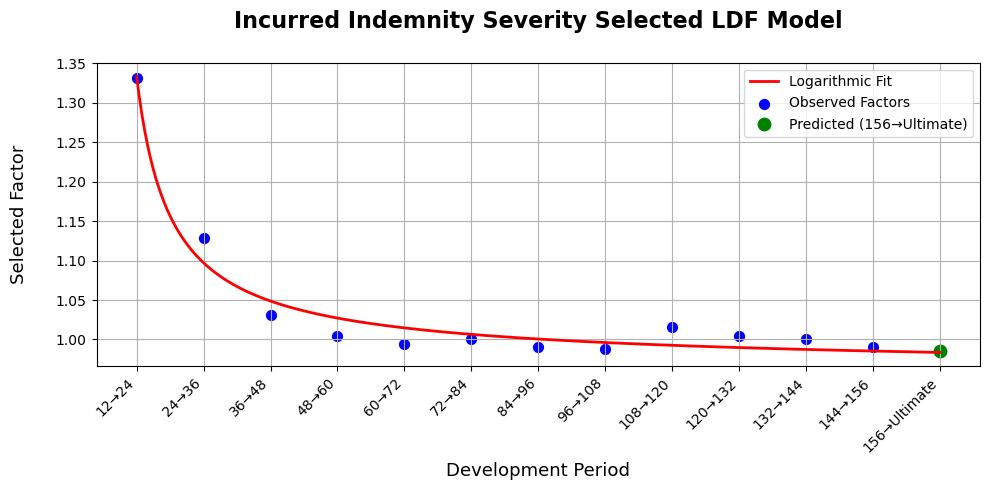

Model Performance Metrics:
  R² (Coefficient of Determination): 0.9682
  MAE (Mean Absolute Error):        0.0146
  RMSE (Root Mean Squared Error):   0.0170

Predicted factor for 156→Ultimate: 0.9853


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------------------------------------
# 1. Data
# --------------------------------------
periods = [
    "12→24", "24→36", "36→48", "48→60", "60→72", "72→84",
    "84→96", "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ultimate"
]

ages = np.array([24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156])
factors = np.array([1.331, 1.129, 1.031, 1.004, 0.994, 1.000, 0.991, 0.988, 1.016, 1.004, 1.001, 0.990])

# --------------------------------------
# 2. Define logarithmic decay model
# --------------------------------------
def log_decay(x, a, b, c):
    return a + b / np.log(c * x)

# --------------------------------------
# 3. Fit model
# --------------------------------------
p0 = [1.0, 1.0, 0.05]  # Initial parameter guesses
params, _ = curve_fit(log_decay, ages, factors, p0=p0, maxfev=10000)
a, b, c = params

# --------------------------------------
# 4. Model predictions and error metrics
# --------------------------------------
fitted_values = log_decay(ages, a, b, c)
r2 = r2_score(factors, fitted_values)
mae = mean_absolute_error(factors, fitted_values)
rmse = np.sqrt(mean_squared_error(factors, fitted_values))

# Predict next factor (156→Ultimate)
predicted_factor = log_decay(156, a, b, c)

# --------------------------------------
# 5. Plot (fitted curve + observed points + prediction)
# --------------------------------------
plt.figure(figsize=(10, 5))

# Fitted curve
x_fit = np.linspace(24, 168, 300)
y_fit = log_decay(x_fit, a, b, c)
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Logarithmic Fit')

# Observed points
plt.scatter(ages, factors, color='blue', s=50, label='Observed Factors')

# Predicted point
plt.scatter(168, predicted_factor, color='green', s=80, label='Predicted (156→Ultimate)')

# X-axis labels as development periods
tick_positions = np.linspace(24, 168, len(periods))
plt.xticks(tick_positions, periods, rotation=45, ha='right', fontsize=10)

# Titles and labels
plt.title("Incurred Indemnity Severity Selected LDF Model",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Development Period", fontsize=13, labelpad=5)
plt.ylabel("Selected Factor", fontsize=13, labelpad=20)

# Grid, legend, layout
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# --------------------------------------
# 6. Print numerical results
# --------------------------------------
print("Model Performance Metrics:")
print(f"  R² (Coefficient of Determination): {r2:.4f}")
print(f"  MAE (Mean Absolute Error):        {mae:.4f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.4f}")
print(f"\nPredicted factor for 156→Ultimate: {predicted_factor:.4f}")


**Reported Medical Tail Factors

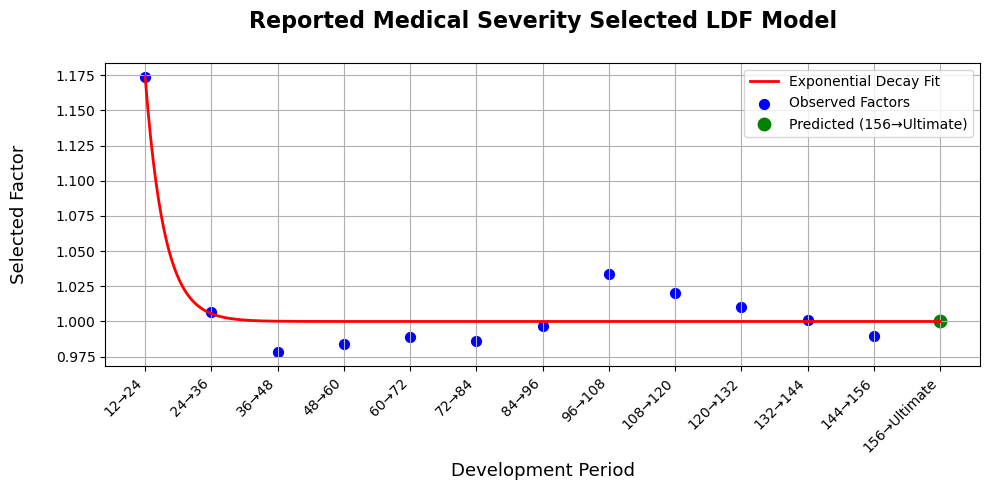

Model Performance Metrics:
  R²:  0.9078
  MAE: 0.0119
  RMSE:0.0154

Predicted factor for 156→Ultimate: 1.0000
Fitted parameters: A=171.7811, B=0.287283


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------------------------------------
# 1. Data
# --------------------------------------
periods = [
    "12→24", "24→36", "36→48", "48→60", "60→72", "72→84",
    "84→96", "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ultimate"
]

ages = np.array([24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156])
factors = np.array([1.174, 1.007, 0.978, 0.984, 0.989, 0.986, 0.997, 1.034, 1.020, 1.010, 1.001, 0.990])

# --------------------------------------
# 2. Define decaying exponential model
# --------------------------------------
def exp_decay(x, A, B):
    return 1 + A * np.exp(-B * x)

# --------------------------------------
# 3. Fit model (best fit, no constraints)
# --------------------------------------
p0 = [0.2, 0.005]  # initial guesses for A and B
params, _ = curve_fit(exp_decay, ages, factors, p0=p0, maxfev=10000)
A, B = params

# --------------------------------------
# 4. Model predictions and error metrics
# --------------------------------------
fitted_values = exp_decay(ages, A, B)
r2 = r2_score(factors, fitted_values)
mae = mean_absolute_error(factors, fitted_values)
rmse = np.sqrt(mean_squared_error(factors, fitted_values))

# Predict next factor (156→Ultimate)
predicted_factor = exp_decay(168, A, B)

# --------------------------------------
# 5. Plot (fitted curve + observed points + prediction)
# --------------------------------------
plt.figure(figsize=(10, 5))

# Fitted curve
x_fit = np.linspace(24, 168, 300)
y_fit = exp_decay(x_fit, A, B)
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Exponential Decay Fit')

# Observed points
plt.scatter(ages, factors, color='blue', s=50, label='Observed Factors')

# Predicted point
plt.scatter(168, predicted_factor, color='green', s=80, label='Predicted (156→Ultimate)')

# X-axis labels as development periods
tick_positions = np.linspace(24, 168, len(periods))
plt.xticks(tick_positions, periods, rotation=45, ha='right', fontsize=10)

# Titles and labels
plt.title("Reported Medical Severity Selected LDF Model",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Development Period", fontsize=13, labelpad=5)
plt.ylabel("Selected Factor", fontsize=13, labelpad=20)

# Grid, legend, layout
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# --------------------------------------
# 6. Print numerical results
# --------------------------------------
print("Model Performance Metrics:")
print(f"  R²:  {r2:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE:{rmse:.4f}")
print(f"\nPredicted factor for 156→Ultimate: {predicted_factor:.4f}")
print(f"Fitted parameters: A={A:.4f}, B={B:.6f}")


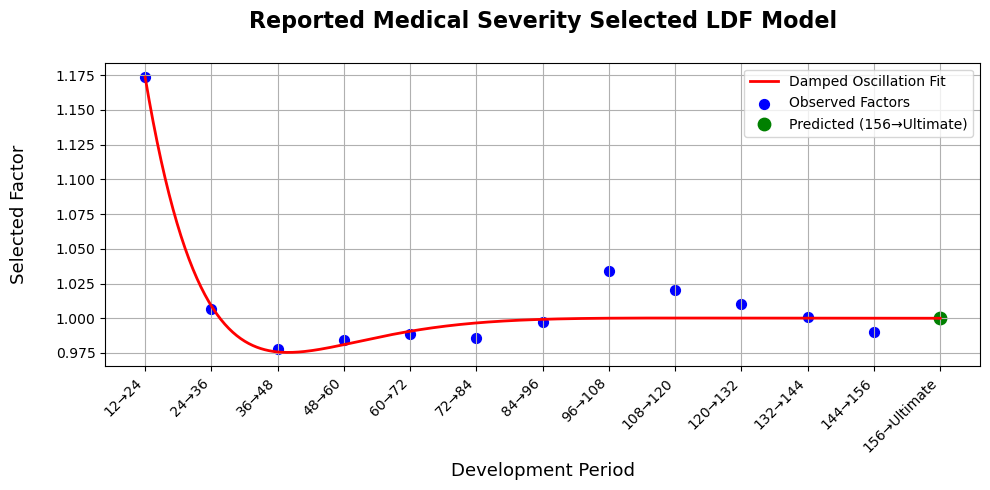

Model Performance Metrics:
  R²:  0.9387
  MAE: 0.0081
  RMSE:0.0125

Predicted factor for 156→Ultimate: 1.0000
Fitted parameters: A=1.7066, B=0.072310, C=0.045400, D=-0.1338


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------------------------------------
# 1. Data
# --------------------------------------
periods = [
    "12→24", "24→36", "36→48", "48→60", "60→72", "72→84",
    "84→96", "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ultimate"
]

ages = np.array([24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156])
factors = np.array([1.174, 1.007, 0.978, 0.984, 0.989, 0.986, 0.997, 1.034, 1.020, 1.010, 1.001, 0.990])

# --------------------------------------
# 2. Define damped oscillation model
# --------------------------------------
def damped_oscillation(x, A, B, C, D):
    return 1 + A * np.exp(-B * x) * np.cos(C * x + D)

# --------------------------------------
# 3. Fit model (best fit)
# --------------------------------------
# Initial guesses for A, B, C, D
p0 = [0.2, 0.01, 0.05, 0]  

params, _ = curve_fit(damped_oscillation, ages, factors, p0=p0, maxfev=20000)
A, B, C, D = params

# --------------------------------------
# 4. Model predictions and error metrics
# --------------------------------------
fitted_values = damped_oscillation(ages, A, B, C, D)
r2 = r2_score(factors, fitted_values)
mae = mean_absolute_error(factors, fitted_values)
rmse = np.sqrt(mean_squared_error(factors, fitted_values))

# Predict next factor (156→Ultimate)
predicted_factor = damped_oscillation(168, A, B, C, D)

# --------------------------------------
# 5. Plot
# --------------------------------------
plt.figure(figsize=(10, 5))

# Fitted curve
x_fit = np.linspace(24, 168, 400)
y_fit = damped_oscillation(x_fit, A, B, C, D)
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Damped Oscillation Fit')

# Observed points
plt.scatter(ages, factors, color='blue', s=50, label='Observed Factors')

# Predicted point
plt.scatter(168, predicted_factor, color='green', s=80, label='Predicted (156→Ultimate)')

# X-axis labels
tick_positions = np.linspace(24, 168, len(periods))
plt.xticks(tick_positions, periods, rotation=45, ha='right', fontsize=10)

# Titles and labels
plt.title("Reported Medical Severity Selected LDF Model",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Development Period", fontsize=13, labelpad=5)
plt.ylabel("Selected Factor", fontsize=13, labelpad=20)

plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# --------------------------------------
# 6. Print results
# --------------------------------------
print("Model Performance Metrics:")
print(f"  R²:  {r2:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE:{rmse:.4f}")
print(f"\nPredicted factor for 156→Ultimate: {predicted_factor:.4f}")
print(f"Fitted parameters: A={A:.4f}, B={B:.6f}, C={C:.6f}, D={D:.4f}")


Paid Ultimate Severities

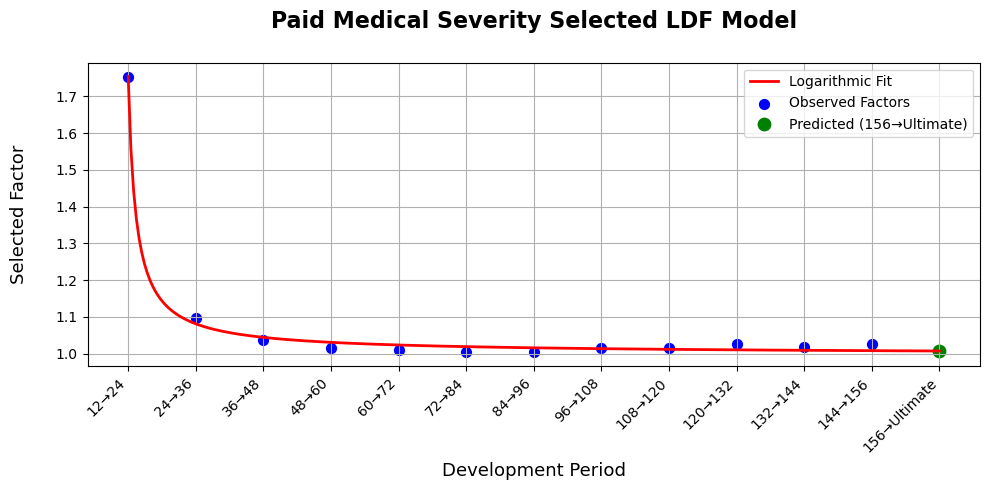

Model Performance Metrics:
  R² (Coefficient of Determination): 0.9964
  MAE (Mean Absolute Error):        0.0108
  RMSE (Root Mean Squared Error):   0.0122

Predicted factor for 156→Ultimate: 1.0078


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------------------------------------
# 1. Data
# --------------------------------------
periods = [
    "12→24", "24→36", "36→48", "48→60", "60→72", "72→84",
    "84→96", "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ultimate"
]

ages = np.array([24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156])
factors = np.array([1.754, 1.096, 1.037, 1.014, 1.009, 1.003, 1.004, 1.016, 1.016, 1.026, 1.018, 1.025])

# --------------------------------------
# 2. Define logarithmic decay model
# --------------------------------------
def log_decay(x, a, b, c):
    return a + b / np.log(c * x)

# --------------------------------------
# 3. Fit model
# --------------------------------------
p0 = [1.0, 1.0, 0.05]
params, _ = curve_fit(log_decay, ages, factors, p0=p0, maxfev=10000)
a, b, c = params

# --------------------------------------
# 4. Model predictions and error metrics
# --------------------------------------
fitted_values = log_decay(ages, a, b, c)
r2 = r2_score(factors, fitted_values)
mae = mean_absolute_error(factors, fitted_values)
rmse = np.sqrt(mean_squared_error(factors, fitted_values))

# Predict next factor (156→Ultimate)
predicted_factor = log_decay(156, a, b, c)

# --------------------------------------
# 5. Plot (fitted curve + observed points + prediction)
# --------------------------------------
plt.figure(figsize=(10, 5))

# Fitted curve
x_fit = np.linspace(24, 168, 300)
y_fit = log_decay(x_fit, a, b, c)
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Logarithmic Fit')

# Observed points
plt.scatter(ages, factors, color='blue', s=50, label='Observed Factors')

# Predicted point
plt.scatter(168, predicted_factor, color='green', s=80, label='Predicted (156→Ultimate)')

# X-axis labels as development periods
tick_positions = np.linspace(24, 168, len(periods))
plt.xticks(tick_positions, periods, rotation=45, ha='right', fontsize=10)

# Titles and labels (larger and spaced away)
plt.title("Paid Medical Severity Selected LDF Model",
          fontsize=16, pad=25, weight='bold')
plt.xlabel("Development Period", fontsize=13, labelpad=5)
plt.ylabel("Selected Factor", fontsize=13, labelpad=20)

# Grid, legend, layout
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# --------------------------------------
# 6. Print numerical results
# --------------------------------------
print("Model Performance Metrics:")
print(f"  R² (Coefficient of Determination): {r2:.4f}")
print(f"  MAE (Mean Absolute Error):        {mae:.4f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.4f}")
print(f"\nPredicted factor for 156→Ultimate: {predicted_factor:.4f}")